# 2024 CITS4012 Project

# Readme

# 1. Dataset Processing

## Importing Libraries

In [2]:
import re
import json
import time
import math
import spacy
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gensim.downloader as api
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from matplotlib.colors import LinearSegmentedColormap

## Loading Datasets

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Load the training data
with open('/content/drive/MyDrive/data/train.json', 'r') as file:
# with open('train.json', 'r') as file:
    data = json.load(file)
    train_data = pd.DataFrame(data['data'], columns=data['columns'])

# Load the test data
with open('/content/drive/MyDrive/data/test.json', 'r') as file:
# with open('test.json', 'r') as file:
    data = json.load(file)
    test_data = pd.DataFrame(data['data'], columns=data['columns'])

# Load the validation data
with open('/content/drive/MyDrive/data/val.json', 'r') as file:
# with open('val.json', 'r') as file:
    data = json.load(file)
    val_data = pd.DataFrame(data['data'], columns=data['columns'])

# Get the x and y lists for training data and test data
training_x = train_data['sentence'].tolist()
training_a = train_data['aspect'].tolist()
training_y = train_data['polarity'].tolist()
val_x = val_data['sentence'].tolist()
val_a = val_data['aspect'].tolist()
val_y = val_data['polarity'].tolist()
test_x = test_data['sentence'].tolist()
test_a = test_data['aspect'].tolist()
test_y = test_data['polarity'].tolist()

## Dataset Analysis

In [6]:
# Size of datasets
print("Training data size :", len(training_x))
print("Test data size     :", len(test_x))

# Aspect Distribution
aspect_distribution = train_data['aspect'].value_counts()
print("\nAspect Distribution:")
print(aspect_distribution.to_string(header=False))

# Polarity Distribution
polarity_distribution = train_data['polarity'].value_counts()
print("\nPolarity Distribution:")
print(polarity_distribution.to_string(header=False))

# Aspect-Sentiment Pair Distribution
aspect_polarity_pair = [(a, p) for a, p in zip(train_data['aspect'], train_data['polarity'])]
aspect_polarity_freq = pd.Series(aspect_polarity_pair).value_counts()
print("\nAspect-Sentiment Pair Distribution:")
print(aspect_polarity_freq.to_string(header=False))

Training data size : 7090
Test data size     : 901

Aspect Distribution:
food             2307
staff            1383
miscellaneous     954
place             694
service           631
menu              475
ambience          324
price             322

Polarity Distribution:
neutral     3077
negative    2084
positive    1929

Aspect-Sentiment Pair Distribution:
(food, neutral)              1298
(staff, negative)             922
(food, positive)              754
(miscellaneous, neutral)      531
(place, neutral)              430
(menu, neutral)               372
(staff, positive)             332
(service, negative)           329
(food, negative)              255
(miscellaneous, positive)     227
(miscellaneous, negative)     196
(ambience, positive)          181
(service, positive)           174
(place, negative)             139
(price, neutral)              136
(staff, neutral)              129
(service, neutral)            128
(place, positive)             125
(price, negative)          

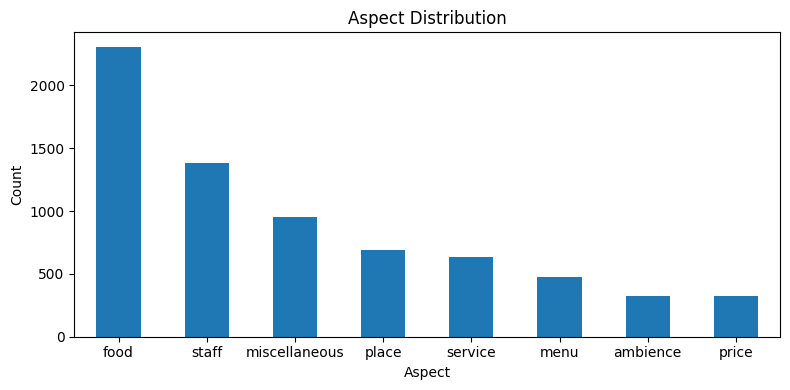

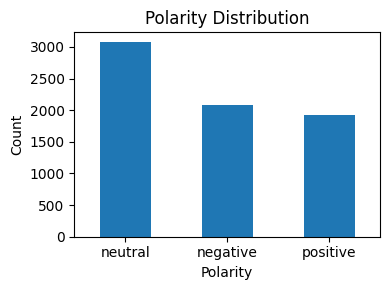

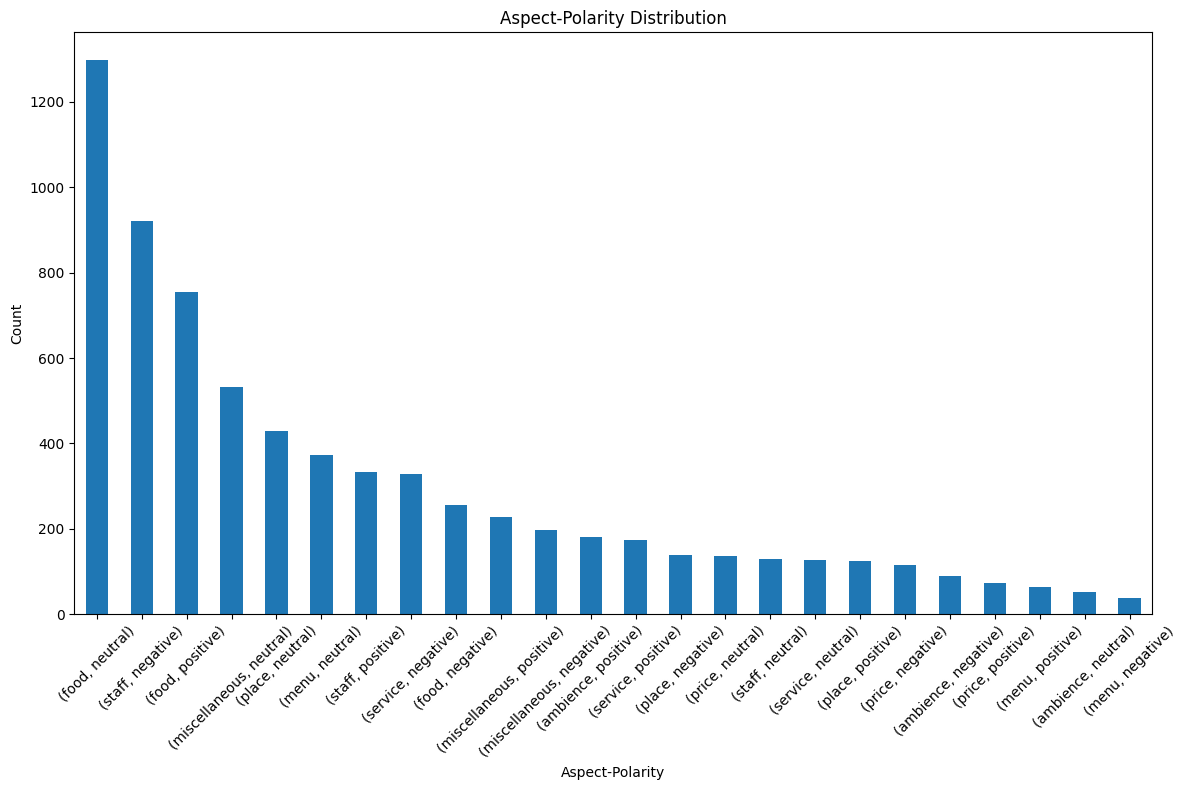

In [7]:
# Function to plot distribution bar graphs
def plot_distribution(figsize, distribution, title, xlabel, rotation=0):
    plt.figure(figsize=figsize)
    distribution.plot(kind='bar')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Count')
    plt.xticks(rotation=rotation)
    plt.tight_layout()
    plt.show()

# Plot Aspect Distribution
plot_distribution((8, 4), aspect_distribution, 'Aspect Distribution', 'Aspect')
# Plot Polarity Distribution
plot_distribution((4, 3), polarity_distribution, 'Polarity Distribution', 'Polarity')
# Plot Aspect-Polarity Distribution
plot_distribution((12, 8), aspect_polarity_freq, 'Aspect-Polarity Distribution', 'Aspect-Polarity', 45)

## Data Preprocessing

In [8]:
! python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 33.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [9]:
# Spacy
nlp = spacy.load("en_core_web_sm")

# Remove certain words from the stop words list
custom_stop_words = [
    "not", "no", "never", "neither", "nor",
    "nobody", "nothing", "nowhere", "none", "cannot",
    "but"
]

for a in custom_stop_words:
    nlp.vocab[a].is_stop = False

# Perform Stopwords Removal, Lemmatisation and Tokenisation
def spacy_processing(x):
    doc = nlp(x)
    x = [word.lemma_ for word in doc if not word.is_stop]
    return x

# English Contractions Dictionary
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have",
                    "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not",
                    "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did",
                    "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have",
                    "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have",
                    "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us",
                    "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have",
                    "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                    "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not",
                    "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
                    "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
                    "so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                    "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                    "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not",
                    "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have",
                    "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have",
                    "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will",
                    "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have",
                    "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have",
                    "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

# Emoticons
EMOTICONS = r"""
    (?:
      [<>]?
      [:;=8]                     # eyes
      [\-o\*\']?                 # optional nose
      [\)\]\(\[dDpP/\:\}\{@\|\\] # mouth
      |
      [\)\]\(\[dDpP/\:\}\{@\|\\] # mouth
      [\-o\*\']?                 # optional nose
      [:;=8]                     # eyes
      [<>]?
      |
      <3                         # heart
    )"""

EMOTICON_RE = re.compile(EMOTICONS, re.VERBOSE | re.I | re.UNICODE)

In [83]:
# Function to preprocess the data
def preprocess_data(sentence_list):
    output_list = []
    for sentence in sentence_list:
        emoticons = EMOTICON_RE.findall(sentence)       # Extract emoticons
        sentence = EMOTICON_RE.sub('', sentence)        # Remove emoticons
        sentence = sentence.lower()                     # Case folding
        for word, new_word in contraction_dict.items(): # Deal with contractions
            sentence = sentence.replace(word, new_word)
        sentence = re.sub(r'[^\w\s]', ' ', sentence)    # Remove punctuation
        sentence = re.sub(r"\s+", " ", sentence)        # Remove extra spaces
        tokens = spacy_processing(sentence)             # Remove stopwords / Lemmatisation / Tokenise
        tokens.extend(emoticons)                        # Add emoticons back
        output_list.append(tokens)
    return output_list

# Preprocess the data and get the tokenised sentence lists
train_x_token = preprocess_data(training_x)
test_x_token = preprocess_data(test_x)
val_x_token = preprocess_data(val_x)

# Function to append aspect to the end of sentence
def append_aspect(token_list, aspect_list, has_sep):
    output = []
    for tokens, aspect in zip(token_list, aspect_list):
        if has_sep:
            new_tokens = tokens + ['<SEP>'] + [aspect]
        else:
            new_tokens = tokens + [aspect]
        output.append(new_tokens)
    return output

# Append aspect to end of sentence
train_xa_sep_token = append_aspect(train_x_token, training_a, has_sep=True)
train_xa_token = append_aspect(train_x_token, training_a, has_sep=False)
test_xa_sep_token = append_aspect(test_x_token, test_a, has_sep=True)
test_xa_token = append_aspect(test_x_token, test_a, has_sep=False)
val_xa_sep_token = append_aspect(val_x_token, val_a, has_sep=True)
val_xa_token = append_aspect(val_x_token, val_a, has_sep=False)

## Create Word Vocabulary

In [84]:
# Word vocabulary to index dictionary {word: index}
word_to_idx = {'<SEP>': 0, '<PAD>': 1}
review = train_x_token + test_x_token + val_x_token
review_aspect = train_xa_token + test_xa_token + val_xa_token
review_aspect_sep = train_xa_sep_token + test_xa_sep_token + val_xa_sep_token
aspect = [list(set(training_a))]
polarity = [list(set(training_y))]
MAX_LENGTH = len(max(review, key=len))                # Maximum length of a sentence
MAX_ASP_LENGTH = len(max(review_aspect, key=len))     # Maximum length of a sentence after appending aspect
MAX_SEP_LENGTH = len(max(review_aspect_sep, key=len)) # Maximum length of a sentence after appending aspect with separator

# Vocabulary includes words from reviews and aspects
for sentence in aspect+review:
    for word in sentence:
        if word not in word_to_idx:
            word_to_idx[word] = len(word_to_idx)
idx_to_word = {idx: word for word, idx in word_to_idx.items()}
word_list = list(word_to_idx.keys())
vocab_size = len(word_to_idx)

# Polarity vocabulary to index dictionary {polarity: index}
polarity_to_idx = {p: i for i, p in enumerate(polarity[0])}
idx_to_polarity = {idx: pol for pol, idx in polarity_to_idx.items()}
polarity_list = list(polarity_to_idx.keys())
num_polarities = len(polarity_to_idx)

## Convert Words to Index form

In [86]:
# Function to convert list of tokens to list of indices (with paddings)
def list_to_index(token_list, word_to_idx, max_seq_length):
    idx_list = []
    for tokens in token_list:
        padded = tokens + ['<PAD>'] * (max_seq_length - len(tokens))
        idx_list.append([word_to_idx[token] for token in padded])
    return idx_list

# Function to convert list of strings to list of indices
def string_to_index(aspect_list, word_to_idx):
    idx_list = []
    for aspect in aspect_list:
        idx_list.append(word_to_idx[aspect])
    return idx_list

def prepare_index_lists(x_token, a, y, xa_token, xa_sep_token):
    x_idx = list_to_index(x_token, word_to_idx, MAX_LENGTH)
    a_idx = string_to_index(a, word_to_idx)
    y_idx = string_to_index(y, polarity_to_idx)
    xa_idx = list_to_index(xa_token, word_to_idx, MAX_ASP_LENGTH)
    xa_sep_idx = list_to_index(xa_sep_token, word_to_idx, MAX_SEP_LENGTH)
    return x_idx, a_idx, y_idx, xa_idx, xa_sep_idx

# Token index lists for training data (with paddings)
train_x_idx, train_a_idx, train_y_idx, train_xa_idx, train_xa_sep_idx = prepare_index_lists(
    train_x_token, training_a, training_y, train_xa_token, train_xa_sep_token)

# Token index lists for test data (with paddings)
test_x_idx, test_a_idx, test_y_idx, test_xa_idx, test_xa_sep_idx = prepare_index_lists(
    test_x_token, test_a, test_y, test_xa_token, test_xa_sep_token)

# Token index lists for validation data (with paddings)
val_x_idx, val_a_idx, val_y_idx, val_xa_idx, val_xa_sep_idx = prepare_index_lists(
    val_x_token, val_a, val_y, val_xa_token, val_xa_sep_token)

## Prepare Batch Data

In [87]:
# Function to prepare data in batches
def prepare_batch(sentences, aspects, polarities, batch_size):
    data = []
    for i in range(len(sentences)):
        x_tensor = torch.LongTensor(sentences[i]).to(device)
        a_tensor = torch.LongTensor([aspects[i]]).to(device)
        y_tensor = torch.LongTensor([polarities[i]]).to(device)
        data.append((x_tensor, a_tensor, y_tensor))
    dataloader = DataLoader(
        data,
        batch_size = batch_size,
        shuffle = True,
        drop_last = True
    )
    return dataloader

## Pretrained Word Embeddings from Glove

In [27]:
# Get Weights for the Embedding Layer (GloVe)
embedding_size = 100
glove_model = api.load("glove-twitter-100")
glove_weights = np.zeros((vocab_size, embedding_size))
for i, word in enumerate(word_to_idx.keys()):
    try:
        # If word in glove, get the weights
        glove_weights[i] = glove_model[word]
    except:
        # If word not in glove, initialise with random weights
        glove_weights[i] = np.random.uniform(low=-0.1, high=0.1, size=embedding_size)

[==================================================] 100.0% 387.1/387.1MB downloaded


# 2. Model Implementation

## Model Variants

In [14]:
# Different aspect integration
NO_ASPECT       = 'no aspect integration'
ASPECT_EMBED    = 'word embedding + aspect embedding'
WITH_SEP        = 'end of sentence with separator'
NO_SEP          = 'end of sentence no separator'
ASPECT_REP_SEP  = 'aspect repeat with separator'
ASPECT_REP      = 'aspect repeat no separator'

# Different attention mechanisms
ATTN_NONE       = 'no_attention'
ATTN_DOT        = 'dot_product'
ATTN_SCALE_DOT  = 'scaled_dot_product'
ATTN_COSINE     = 'cosine_similarity'

## Model Architecture

## Model 1 (Append Aspect)

In [88]:
class Model1(nn.Module):
    # Initialise the model
    def __init__(self, hidden_size, output_size, batch_size, embedding, attention='dot_product'):
        super(Model1, self).__init__()
        self.attention_type = attention
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.embedding = embedding
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(self.hidden_size, self.output_size)
        self.linear_attention = nn.Linear(self.hidden_size*2, self.output_size)

    # Forward propagation
    def forward(self, input, aspect):
        sentence_embeddings = self.embedding(input)
        outputs, (hidden, cell) = self.lstm(sentence_embeddings)
        # outputs = [batch_size, seq_length, hidden_size]
        # hidden  = [num_layers=1, batch_size, hidden_size]
        attn_weights = torch.bmm(outputs, hidden.squeeze(0).unsqueeze(2))
        attn_weights = F.softmax(attn_weights.squeeze(2), dim=1)
        attn_output = torch.bmm(outputs.transpose(1, 2), attn_weights.unsqueeze(2)).squeeze(2)
        concat_output = torch.cat((attn_output, hidden.squeeze(0)), dim=1)
        output = F.log_softmax(self.linear_attention(concat_output), dim=1)
        return output

## Model 2 (Aspect embeddings)

In [112]:
# LSTM Model
class Model2(nn.Module):
    # Initialise the model
    def __init__(self, hidden_size, output_size, batch_size, embedding, attention='dot_product'):
        super(Model2, self).__init__()
        self.attention_type = attention
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.embedding = embedding
        self.lstm = nn.LSTM(hidden_size*2, hidden_size, batch_first=True)
        self.linear = nn.Linear(self.hidden_size, self.output_size)
        self.linear_attention = nn.Linear(self.hidden_size*2, self.output_size)

    # Forward propagation
    def forward(self, input, aspect):
        sentence_embeddings = self.embedding(input)
        aspect_embeddings = []
        for batch in range(aspect.size(0)):
            valid_length = (aspect[batch, :] != 0).sum()
            aspect_embeddings.append(self.embedding(aspect[batch, :valid_length]).mean(dim=0).unsqueeze(dim=0))
        aspect_embeddings = torch.cat(aspect_embeddings, dim=0) # [batch_size, hidden_size]
        e1 = sentence_embeddings
        e2 = aspect_embeddings.view(self.batch_size, 1, self.hidden_size).expand(self.batch_size, MAX_LENGTH, self.hidden_size)
        wv = torch.cat((e1, e2), dim=-1)
        outputs, (hidden, cell) = self.lstm(wv)
        attn_weights = torch.bmm(outputs, hidden.squeeze(0).unsqueeze(2))
        attn_weights = F.softmax(attn_weights.squeeze(2), dim=1)
        attn_output = torch.bmm(outputs.transpose(1, 2), attn_weights.unsqueeze(2)).squeeze(2)
        concat_output = torch.cat((attn_output, hidden.squeeze(0)), dim=1)
        output = F.log_softmax(self.linear_attention(concat_output), dim=1)
        # output = F.softmax(self.linear(h.squeeze()), dim=1)
        return output

## Test model

In [128]:
# LSTM Model
class Model3(nn.Module):
    # Initialise the model
    def __init__(self, hidden_size, output_size, batch_size, embedding, attention='dot_product'):
        super(Model3, self).__init__()
        self.attention_type = attention
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.embedding = embedding
        self.lstm = nn.LSTM(hidden_size*2, hidden_size, batch_first=True)
        self.linear = nn.Linear(self.hidden_size, self.output_size)
        self.linear_attention = nn.Linear(self.hidden_size*2, self.output_size)
        self.linear_concat = nn.Linear(self.hidden_size*2, self.hidden_size)

    # Forward propagation
    def forward(self, input, aspect):
        sentence_embeddings = self.embedding(input)
        aspect_embeddings = []
        for batch in range(aspect.size(0)):
            valid_length = (aspect[batch, :] != 0).sum()
            aspect_embeddings.append(self.embedding(aspect[batch, :valid_length]).mean(dim=0).unsqueeze(dim=0))
        aspect_embeddings = torch.cat(aspect_embeddings, dim=0) # [batch_size, hidden_size]
        e1 = sentence_embeddings
        e2 = aspect_embeddings.view(self.batch_size, 1, self.hidden_size).expand(self.batch_size, MAX_LENGTH, self.hidden_size)
        wv = torch.cat((e1, e2), dim=-1)
        outputs, (hidden, cell) = self.lstm(wv)
        outputs = torch.cat((outputs, e2), dim=-1)
        outputs = self.linear_concat(outputs)
        attn_weights = torch.bmm(outputs, hidden.squeeze(0).unsqueeze(2))
        attn_weights = F.softmax(attn_weights.squeeze(2), dim=1)
        attn_output = torch.bmm(outputs.transpose(1, 2), attn_weights.unsqueeze(2)).squeeze(2)
        concat_output = torch.cat((attn_output, hidden.squeeze(0)), dim=1)
        output = F.log_softmax(self.linear_attention(concat_output), dim=1)
        # output = F.softmax(self.linear(h.squeeze()), dim=1)
        return output

## Helper Functions for Training
- asMinutes() : Convert time to minutes
- timeSince() : Calculate time since last checkpoint
- prepare_input_tensors(): Prepare input tensors for different integration types
- prepare_data() : Prepare tensor data for training
- feed_sequence() : Feed sequence word by word to model

In [16]:
# Function to get time elapsed during training
# Reference: https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

# Function to feed input tensor during training
def feed_sequence(model, input_tensor, aspect_tensor, max_length):
    hiddens = torch.zeros(max_length, model.hidden_size, device=device)  # For attention mechanism
    hidden = model.init_hidden()                          # Hidden state
    cell = model.init_hidden()                            # Cell state
    for i in range(input_tensor.size(0)):
        is_last = (i==input_tensor.size(0)-1)
        if is_last:
            y_output, (_, _), _ = model(input_tensor[i], hidden, cell, hiddens, aspect_tensor, is_last=is_last)
        else:
            _, (hidden, cell), _ = model(input_tensor[i], hidden, cell, hiddens, aspect_tensor, is_last=is_last)
            hiddens[i] = hidden[0, 0]
    return y_output

## Function to Train Model
- train() : Train model on training data based on different integration types
- plot_graphs() : Plot average loss or accuracy graph over epochs
- Note: have to run the [Evaluation functions](#evaluation) for Accuracy graph visualisation

In [122]:
# Function to train model
def train(embedding, attention_type, integration_type, batch_size=64,
          num_epochs=10000, print_interval=500, plot_interval=200,
          learning_rate=0.001, hidden_size=100, accuracy_graph=False):

    model = Model3(hidden_size, num_polarities, batch_size, embedding, attention_type).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    plot_accuracy, plot_avg_losses, print_loss_total, plot_loss_total = [], [], 0, 0
    start = time.time()
    plot_all = []

    for epoch in range(1, num_epochs+1):
        # Prepare batches based on integration type
        if integration_type == ASPECT_EMBED:
            sentences = train_x_idx
        elif integration_type == NO_SEP:
            sentences = train_xa_idx
        elif integration_type == WITH_SEP:
            sentences = train_xa_sep_idx
        train_batches = prepare_batch(sentences, train_a_idx, train_y_idx, batch_size)

        for i, batch_data in enumerate(train_batches):

            (input, aspect, target) = batch_data

            model.train()
            optimizer.zero_grad()

            output = model(input, aspect)

            loss = criterion(output, target.squeeze())
            loss.backward()
            optimizer.step()

            print_loss_total += loss.item()
            plot_loss_total += loss.item()
            plot_all.append(loss.item())

        if epoch % print_interval == 0:
            print_avg_loss = print_loss_total / ((i+1)*print_interval)
            print_time = timeSince(start, epoch / num_epochs)
            print(f'{print_time} Epoch [{epoch}/{num_epochs}] Loss: {print_avg_loss:.4f}')
            print_loss_total = 0

        if epoch % plot_interval == 0:
            # Calculate average loss over plot interval
            plot_avg_loss = plot_loss_total / ((i+1)*plot_interval)
            plot_avg_losses.append(plot_avg_loss)
            plot_loss_total = 0

            # Calculate accuracy on validation set
            if accuracy_graph:
                accuracy = evaluate(model, is_test=False)
                plot_accuracy.append(accuracy)

    return model, plot_avg_losses, plot_accuracy, plot_all

# Function to plot average loss or accuracy graph over epochs
def plot_graphs(num_epochs, interval, plot_data, title, metric):
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, num_epochs+1, interval), plot_data)
    plt.title(f'{metric.capitalize()} over Epochs ({title})')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.tight_layout()
    plt.show()

## Selected Hyperparameters

In [43]:
# Set hyperparameters
num_epochs       = 10000
print_interval   = 500
plot_interval    = 200
learning_rate    = 0.001
hidden_size      = 100
batch_size       = 64

# 3. Testing and Evaluation

## Functions to Visualise Attention Weights
- plot_attention() : Plot attention weights for a given sentence

In [44]:
# Define custom colormap with Blue as highest values and white as lowest values
colors = [(1, 1, 1), (0.2, 0.4, 1)]  # White to Blue
cmap_name = 'custom_blue_white'
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)

# Function to plot attention weights for a sentence
def plot_attention(words, attention_weights, sentence, aspect, pred_polarity, true_polarity):
    # Create figure and axis
    size = len(words)
    fig, ax = plt.subplots(figsize=(size, 2))
    norm = plt.Normalize(vmin=0, vmax=0.1)

    # Plot each word with attention weight as colored box
    for i, (word, weight) in enumerate(zip(words, attention_weights)):
        # Plot word
        ax.text(i, 0.5, word, ha='center', va='center', fontsize=12)

        # Plot colored box above word
        color = custom_cmap(norm(weight))
        rect = plt.Rectangle((i - 0.5, 0.6), 1, 0.4, color=color, ec='black')
        ax.add_patch(rect)

    # Set x-axis and y-axis properties
    ax.set_xlim(-0.5, size - 0.5)

    # Remove x-axis and y-axis lines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # Hide ticks on x-axis and y-axis
    ax.tick_params(axis='both', which='both', bottom=False, left=False)
    ax.set_xticks(range(len(words)))
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_title(f'Aspect: {aspect} | Predicted Polarity: {pred_polarity} | True Polarity: {true_polarity}', fontsize=14)

    # Add colorbar legend
    sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
    sm.set_array([])
    ax.text(-1, 0.2, sentence, ha='left', va='center', fontsize=12)
    fig.subplots_adjust(top=0.9, bottom=0.2, left=0.05, right=0.95)

    # Show plot
    plt.show()

## Function to Evaluate Model
- predict() : Predict polarity of a given sentence based on an aspect
- evaluate() : Evaluate model on val/test data and return accuracy
<a id="evaluation"></a>

In [94]:
# Function to get words and their corresponding attention weights
def get_words_weights(input_words, attn_weights, integration_type):
    words = []
    weights = []
    for i, word in enumerate(input_words):
        if ((integration_type == ASPECT_REP and i % 2 == 0) or
            (integration_type == ASPECT_REP_SEP and i % 3 == 0) or
            (integration_type == WITH_SEP and i < len(input_words) - 2) or
            (integration_type == NO_SEP and i < len(input_words) - 1) or
            (integration_type == NO_ASPECT or integration_type == ASPECT_EMBED)):
            words.append(word)
            weights.append(attn_weights[i])
    return words, weights

# Function to calculate model accuracy on test data
def evaluate(model, integration_type, is_test=True):
    model.eval()
    with torch.no_grad():
        # Prepare batches based on integration type
        if integration_type == ASPECT_EMBED:
            sentences = test_x_idx if is_test else val_x_idx
        elif integration_type == NO_SEP:
            sentences = test_xa_idx if is_test else val_xa_idx
        elif integration_type == WITH_SEP:
            sentences = test_xa_sep_idx if is_test else val_xa_sep_idx
        aspects = test_a_idx if is_test else val_a_idx
        polarities = test_y_idx if is_test else val_y_idx
        data_batches = prepare_batch(sentences, aspects, polarities, batch_size)

        correct = 0
        for (input, aspect, target) in data_batches:
            outputs = model(input, aspect)
            _, topi = outputs.data.topk(1)
            for output, target in zip(topi, target):
                predicted = polarity_list[output.item()]
                actual = polarity_list[target.item()]
                if predicted == actual:
                    correct += 1
        accuracy = correct / len(test_data)
    return accuracy

## No Aspect

In [ ]:
# Set different attention and integration types
attention_type   = ATTN_DOT
integration_type = NO_ASPECT

embedding0 = nn.Embedding(vocab_size, hidden_size)
embedding0.weight.data.copy_(torch.from_numpy(glove_weights))

# Train the model
model0, plot_avg_losses0, plot_accuracy0 = train(embedding0, attention_type, integration_type,
                                                 num_epochs=num_epochs, learning_rate=learning_rate,
                                                 hidden_size=hidden_size, accuracy_graph=False)

# Get the accuracy of the model on test data
accuracy0 = evaluate(model0, test_x, test_a, test_y, integration_type)
print(f"Accuracy: {accuracy0:.4f}")

0m 5s (- 1m 52s) Epoch [500/10000] Loss: 1.0673
0m 11s (- 1m 45s) Epoch [1000/10000] Loss: 1.0538
0m 17s (- 1m 39s) Epoch [1500/10000] Loss: 1.0370
0m 23s (- 1m 32s) Epoch [2000/10000] Loss: 1.0125
0m 29s (- 1m 28s) Epoch [2500/10000] Loss: 0.9916
0m 35s (- 1m 22s) Epoch [3000/10000] Loss: 0.9686
0m 41s (- 1m 16s) Epoch [3500/10000] Loss: 0.9438
0m 47s (- 1m 10s) Epoch [4000/10000] Loss: 0.9675
0m 53s (- 1m 5s) Epoch [4500/10000] Loss: 0.9302
0m 59s (- 0m 59s) Epoch [5000/10000] Loss: 0.9633
1m 5s (- 0m 53s) Epoch [5500/10000] Loss: 0.9561
1m 11s (- 0m 47s) Epoch [6000/10000] Loss: 0.9043
1m 17s (- 0m 41s) Epoch [6500/10000] Loss: 0.9080
1m 23s (- 0m 35s) Epoch [7000/10000] Loss: 0.9253
1m 30s (- 0m 30s) Epoch [7500/10000] Loss: 0.8683
1m 36s (- 0m 24s) Epoch [8000/10000] Loss: 0.9116
1m 42s (- 0m 18s) Epoch [8500/10000] Loss: 0.9160
1m 48s (- 0m 12s) Epoch [9000/10000] Loss: 0.8801
1m 55s (- 0m 6s) Epoch [9500/10000] Loss: 0.8559
2m 1s (- 0m 0s) Epoch [10000/10000] Loss: 0.8946
Accura

## Word Embedding + Aspect Embedding

In [129]:
# Set hyperparameters
num_epochs       = 20
print_interval   = 1
plot_interval    = 1
learning_rate    = 0.001
hidden_size      = 100
batch_size       = 32

# Get word embeddings
embedding1 = nn.Embedding(vocab_size, hidden_size)
embedding1.weight.data.copy_(torch.from_numpy(glove_weights))
# print("Shape of the embedding weights:", embedding.weight.data.shape)

# Set different attention and integration types
attention_type   = ATTN_DOT
integration_type = ASPECT_EMBED

# Train the model
model1, plot_avg_losses1, plot_accuracy1, plot_all1 = train(embedding1, attention_type, integration_type, batch_size=batch_size,
                                                            num_epochs=num_epochs, print_interval=print_interval,
                                                            plot_interval=plot_interval, learning_rate=learning_rate,
                                                            hidden_size=hidden_size, accuracy_graph=True)

# Get the accuracy of the model on test data
accuracy1 = evaluate(model1, integration_type)
print(f"Accuracy: {accuracy1:.4f}")

0m 2s (- 0m 56s) Epoch [1/20] Loss: 0.8985
0m 8s (- 1m 18s) Epoch [2/20] Loss: 0.7849
0m 13s (- 1m 14s) Epoch [3/20] Loss: 0.6977
0m 16s (- 1m 6s) Epoch [4/20] Loss: 0.6121
0m 20s (- 1m 0s) Epoch [5/20] Loss: 0.5279
0m 24s (- 0m 57s) Epoch [6/20] Loss: 0.4284
0m 28s (- 0m 52s) Epoch [7/20] Loss: 0.3470
0m 31s (- 0m 47s) Epoch [8/20] Loss: 0.2876
0m 35s (- 0m 42s) Epoch [9/20] Loss: 0.2149
0m 39s (- 0m 39s) Epoch [10/20] Loss: 0.1715
0m 42s (- 0m 34s) Epoch [11/20] Loss: 0.1406
0m 46s (- 0m 30s) Epoch [12/20] Loss: 0.1059
0m 50s (- 0m 27s) Epoch [13/20] Loss: 0.0715
0m 54s (- 0m 23s) Epoch [14/20] Loss: 0.0755
0m 57s (- 0m 19s) Epoch [15/20] Loss: 0.0745
1m 1s (- 0m 15s) Epoch [16/20] Loss: 0.0477
1m 5s (- 0m 11s) Epoch [17/20] Loss: 0.0550
1m 8s (- 0m 7s) Epoch [18/20] Loss: 0.0497
1m 13s (- 0m 3s) Epoch [19/20] Loss: 0.0363
1m 18s (- 0m 0s) Epoch [20/20] Loss: 0.0423
Accuracy: 0.6870


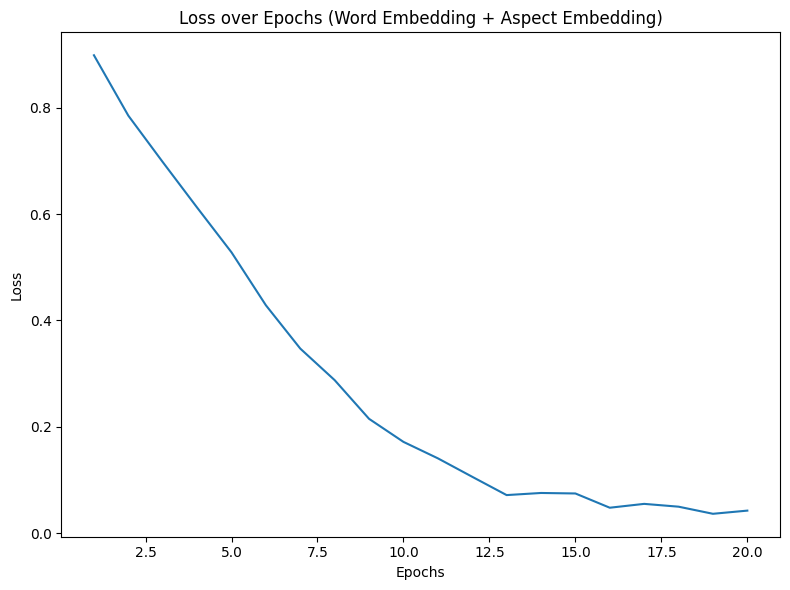

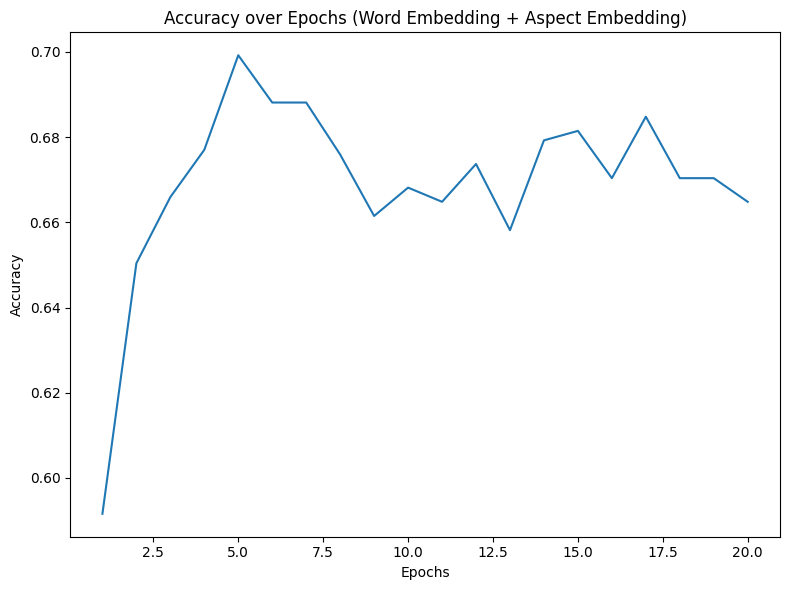

In [130]:
plot_graphs(num_epochs, plot_interval, plot_avg_losses1, 'Word Embedding + Aspect Embedding', 'Loss')
plot_graphs(num_epochs, plot_interval, plot_accuracy1, 'Word Embedding + Aspect Embedding', 'Accuracy')

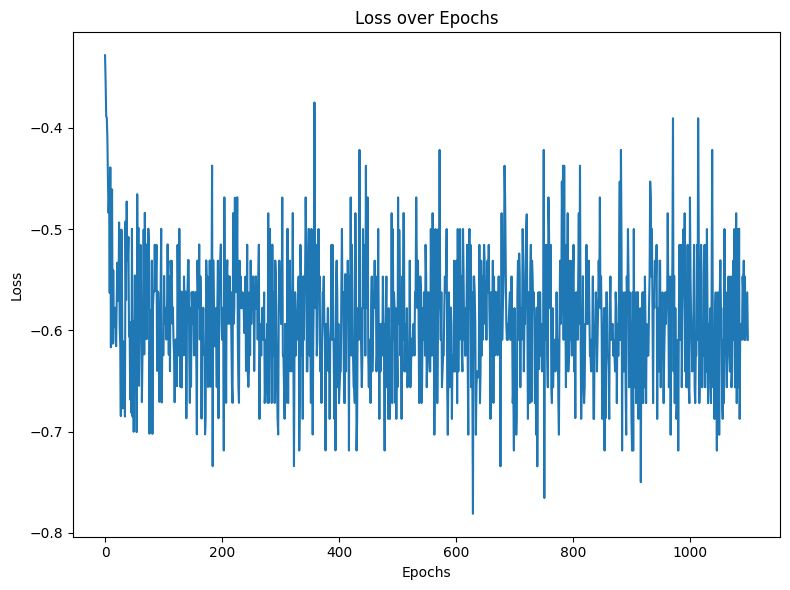

In [64]:
plt.figure(figsize=(8, 6))
plt.plot(range(len(plot_all)), plot_all)
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()

## Sentence + Aspect with Separator

In [109]:
# Set hyperparameters
num_epochs       = 20
print_interval   = 1
plot_interval    = 1
learning_rate    = 0.001
hidden_size      = 100
batch_size       = 32

# Get word embeddings
embedding = nn.Embedding(vocab_size, hidden_size)
embedding.weight.data.copy_(torch.from_numpy(glove_weights))
# print("Shape of the embedding weights:", embedding.weight.data.shape)

# Set different attention and integration types
attention_type   = ATTN_DOT
integration_type = WITH_SEP

# Train the model
model4, plot_avg_losses4, plot_accuracy4, plot_all4 = train(embedding, attention_type, integration_type, batch_size=batch_size,
                                                            num_epochs=num_epochs, print_interval=print_interval,
                                                            plot_interval=plot_interval, learning_rate=learning_rate,
                                                            hidden_size=hidden_size, accuracy_graph=True)

# Get the accuracy of the model on test data
accuracy4 = evaluate(model4, integration_type)
print(f"Accuracy: {accuracy4:.4f}")

0m 2s (- 0m 43s) Epoch [1/20] Loss: 0.9771
0m 3s (- 0m 32s) Epoch [2/20] Loss: 0.8408
0m 5s (- 0m 28s) Epoch [3/20] Loss: 0.7784
0m 6s (- 0m 27s) Epoch [4/20] Loss: 0.7288
0m 8s (- 0m 25s) Epoch [5/20] Loss: 0.6896
0m 10s (- 0m 23s) Epoch [6/20] Loss: 0.6495
0m 11s (- 0m 21s) Epoch [7/20] Loss: 0.6728
0m 13s (- 0m 19s) Epoch [8/20] Loss: 0.6653
0m 14s (- 0m 17s) Epoch [9/20] Loss: 0.5932
0m 15s (- 0m 15s) Epoch [10/20] Loss: 0.5600
0m 17s (- 0m 14s) Epoch [11/20] Loss: 0.5244
0m 19s (- 0m 13s) Epoch [12/20] Loss: 0.4985
0m 22s (- 0m 12s) Epoch [13/20] Loss: 0.4750
0m 27s (- 0m 11s) Epoch [14/20] Loss: 0.4551
0m 29s (- 0m 9s) Epoch [15/20] Loss: 0.4292
0m 32s (- 0m 8s) Epoch [16/20] Loss: 0.4979
0m 34s (- 0m 6s) Epoch [17/20] Loss: 0.5551
0m 35s (- 0m 3s) Epoch [18/20] Loss: 0.4628
0m 38s (- 0m 2s) Epoch [19/20] Loss: 0.4119
0m 40s (- 0m 0s) Epoch [20/20] Loss: 0.4218
Accuracy: 0.6337


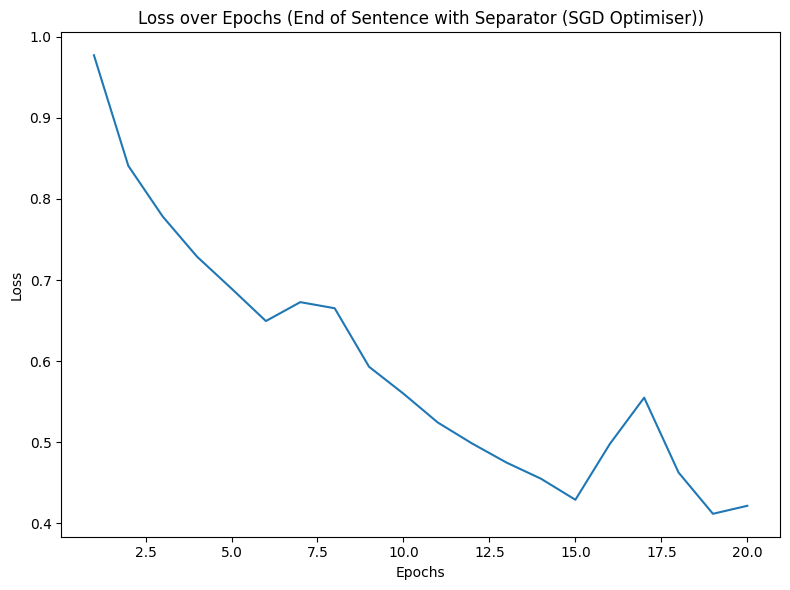

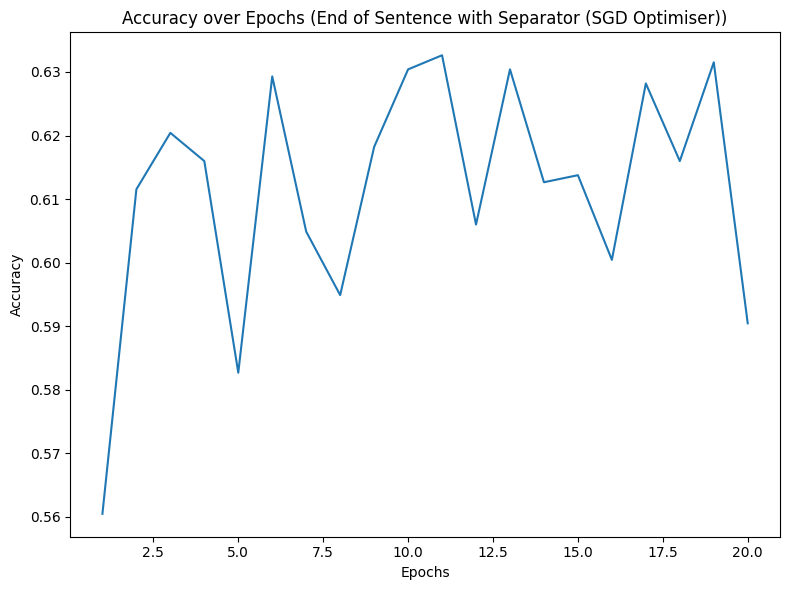

In [111]:
plot_graphs(num_epochs, plot_interval, plot_avg_losses4, 'End of Sentence with Separator (SGD Optimiser)', 'Loss')
plot_graphs(num_epochs, plot_interval, plot_accuracy4, 'End of Sentence with Separator (SGD Optimiser)', 'Accuracy')

## Sentence + Aspect no Separator

In [ ]:
# Set different attention and integration types
attention_type   = ATTN_DOT
integration_type = NO_SEP

embedding5 = nn.Embedding(vocab_size, hidden_size)
embedding5.weight.data.copy_(torch.from_numpy(glove_weights))

# Train the model
model5, plot_avg_losses5, plot_accuracy5 = train(embedding5, attention_type, integration_type,
                                                 num_epochs=num_epochs, learning_rate=learning_rate,
                                                 hidden_size=hidden_size, accuracy_graph=False)

# Get the accuracy of the model on test data
accuracy5 = evaluate(model5, test_x, test_a, test_y, integration_type)
print(f"Accuracy: {accuracy5:.4f}")

Accuracy: 0.6548


## Visualisation of Average Loss over Epochs

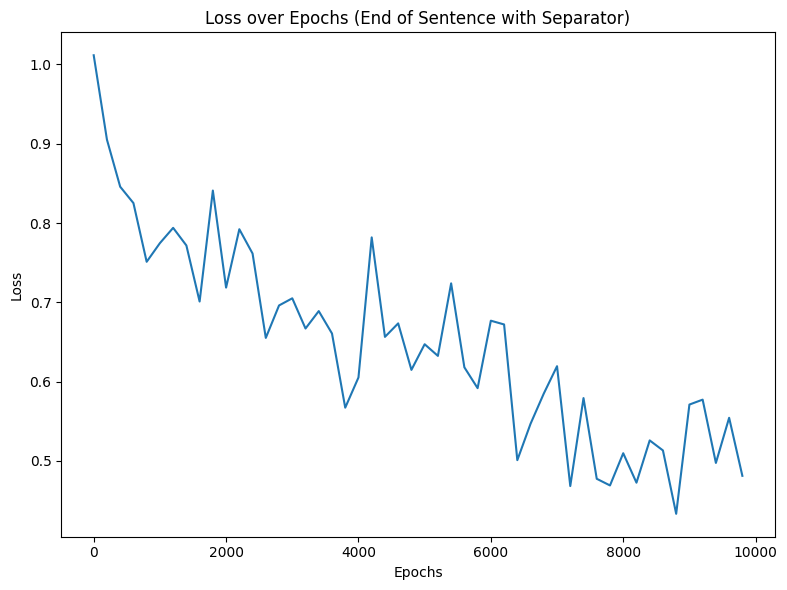

In [ ]:
plot_graphs(num_epochs, plot_interval, plot_avg_losses0, 'No Aspect Integration', 'Loss')
plot_graphs(num_epochs, plot_interval, plot_avg_losses1, 'Word Embedding + Aspect Embedding', 'Loss')
plot_graphs(num_epochs, plot_interval, plot_avg_losses2, 'Aspect Repeat with Separator', 'Loss')
plot_graphs(num_epochs, plot_interval, plot_avg_losses3, 'Aspect Repeat no Separator', 'Loss')
plot_graphs(num_epochs, plot_interval, plot_avg_losses4, 'End of Sentence with Separator', 'Loss')
plot_graphs(num_epochs, plot_interval, plot_avg_losses5, 'End of Sentence no Separator', 'Loss')

## Visualisation of Accuracy over Epochs

In [ ]:
plot_graphs(num_epochs, plot_interval, plot_accuracy0, 'No Aspect Integration', 'Accuracy')
plot_graphs(num_epochs, plot_interval, plot_accuracy1, 'Word Embedding + Aspect Embedding', 'Accuracy')
plot_graphs(num_epochs, plot_interval, plot_accuracy2, 'Aspect Repeat with Separator', 'Accuracy')
plot_graphs(num_epochs, plot_interval, plot_accuracy3, 'Aspect Repeat no Separator', 'Accuracy')
plot_graphs(num_epochs, plot_interval, plot_accuracy4, 'End of Sentence with Separator', 'Accuracy')
plot_graphs(num_epochs, plot_interval, plot_accuracy5, 'End of Sentence no Separator', 'Accuracy')

## Visualisation of Attention Weights

Original sentence: The food was good, but it's not worth the wait--or the lousy service.
Preprocessed sentence: ['food', 'good', 'but', 'not', 'worth', 'wait', 'lousy', 'service']


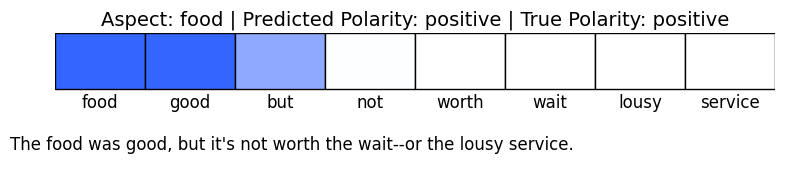

Original sentence: The food was good, but it's not worth the wait--or the lousy service.
Preprocessed sentence: ['food', 'good', 'but', 'not', 'worth', 'wait', 'lousy', 'service']


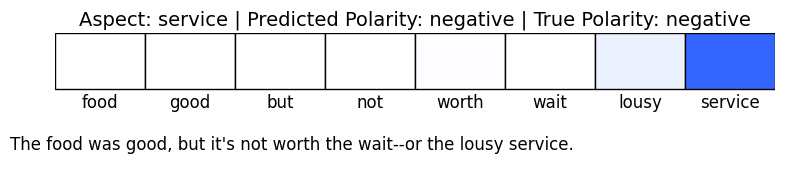

Original sentence: The ambience is stunning and the food is really good, but the portions are RIDICULOUSLY small.
Preprocessed sentence: ['ambience', 'stunning', 'food', 'good', 'but', 'portion', 'ridiculously', 'small']


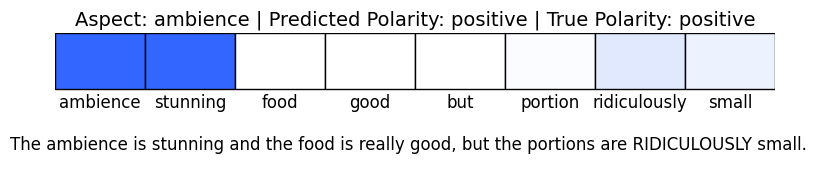

Original sentence: The ambience is stunning and the food is really good, but the portions are RIDICULOUSLY small.
Preprocessed sentence: ['ambience', 'stunning', 'food', 'good', 'but', 'portion', 'ridiculously', 'small']


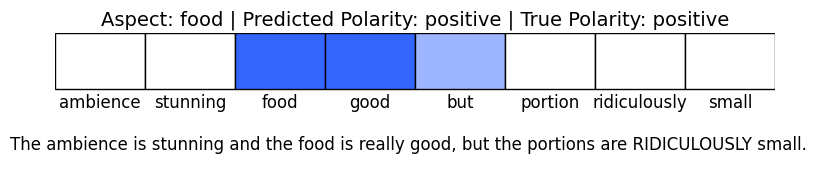

Original sentence: The ambience is stunning and the food is really good, but the portions are RIDICULOUSLY small.
Preprocessed sentence: ['ambience', 'stunning', 'food', 'good', 'but', 'portion', 'ridiculously', 'small']


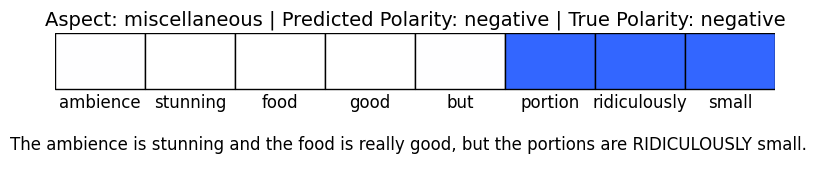

In [ ]:
# Function to visualise the attention weights for a sentence
def visualise_sentence(model, sentence, aspect, polarity, integration_type):
    pred_polarity, attention_weights, input_tensor = predict(model, sentence, aspect, integration_type)
    input_words = [idx_to_word[idx[0]] for idx in input_tensor.tolist()]
    attn_weights = attention_weights[0].tolist()[0][0][:len(input_words)]
    words, weights = get_words_weights(input_words, attn_weights, integration_type)
    print("Original sentence:", sentence)
    print("Preprocessed sentence:", preprocess_data([sentence])[0])
    plot_attention(words, weights, sentence, aspect, pred_polarity, polarity)

# Test sample instances
sentences = [test_x[2], test_x[3], test_x[528], test_x[529], test_x[530]]
aspects = [test_a[2], test_a[3], test_a[528], test_a[529], test_a[530]]
polarities = [test_y[2], test_y[3], test_y[528], test_y[529], test_y[530]]

# Visualise the attention weights for the sample instances
# Model 4: End of Sentence with Separator
for i in range(len(sentences)):
    visualise_sentence(model4, sentences[i], aspects[i], polarities[i], integration_type)